In [1]:
import os 
from glob import glob
from datetime import datetime

import numpy as np
import jax
import jax.numpy as jnp

import xarray as xr
import pandas as pd
import dask

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import cartopy.feature as cfeature

from water_balance_jax import wbm_jax, construct_Kpet_vec
from initial_params import initial_params_main, initial_params_vic, constants
from param_bounds import params_main_lower, params_main_upper, params_vic_lower, params_vic_upper
from read_inputs import read_inputs
from param_names import param_names_main, param_names_vic
from prediction import make_prediction_main, make_prediction_vic
from global_paths import project_data_path

In [2]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50

## Preliminaries

In [3]:
def get_jax_top(subset_name, obs_name, metric, iden):
    # Loop through files
    files = glob(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/*{iden}*.txt')

    # Record count, corr, best RMSE, surprise index
    df_out = []
    for file in files:
        # Read
        # columns = ['epoch', 'metric', 'train_loss', 'pred_loss', 'reg_loss', 'val_loss'] + param_names
        df = pd.read_csv(file, sep = ' ').dropna(thresh = 7) #, names = columns).iloc[1:]
        
        # Take best val
        df_best = df.sort_values(by=metric).iloc[:1]
        df_out.append(df_best)

    # Join and return
    df_out = pd.concat(df_out)
    return df_out

In [4]:
def simulate_jax(subset_name, obs_name, theta):
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)

    if obs_name == "VIC":
        make_prediction = make_prediction_vic
    else:
        make_prediction = make_prediction_main
    
    spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

    out = spatial_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    return ds_sim

In [5]:
# Plotting function
def plot_jax_map(subset_name, obs_name, metric, iden, plot_type, cbar, title, ax):
    """
    Plots the RMSE, coverage, or linear correlation map for a given obs-product.
    """
    if obs_name == "VIC":
        param_names = param_names_vic
    else:
        param_names = param_names_main
        
    # Get obs
    obs = np.load(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.npy")
    # Construct xr 
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat
    nt = obs.shape[2]
    ds_obs = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(obs.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))
    ds_obs = ds_obs['soilMoist']
    ds_obs = ds_obs.where(~ds_obs.isnull().any(dim='time'))
    
    # Get top params
    df_params = get_jax_top(subset_name, obs_name, metric, iden)
    
    # Param names
    if obs_name == "VIC":
        param_names = param_names_vic
    else:
        param_names = param_names_main
    
    if plot_type == 'coverage': 
        maxs = np.zeros(ds_obs.shape)
        mins = np.ones(ds_obs.shape) * 1000
    
        # Get ensemble bounds
        for index in range(len(df_params)):
            # Simulate
            ds_tmp = xr.open_dataset(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_out/{str(thresh)}thresh_{str(index)}.nc')['soilMoist']
            
            # Iterativalely calculate bounds
            maxs = np.max([maxs, ds_tmp.to_numpy()], axis=0)
            mins = np.min([mins, ds_tmp.to_numpy()], axis=0)
    
        # Get coverage
        coverage = 100 * (1 - ((((ds_obs.to_numpy() > maxs).sum(axis=0) + (ds_obs.to_numpy() < mins).sum(axis=0))) / ds_obs.shape[0]))

        # Construct ds for coverage
        ds_coverage = xr.Dataset(
            data_vars=dict(coverage=(["lat", "lon"], np.ma.masked_array(coverage, np.isnan(maxs[0,:,:])))),
            coords=dict(
                lon=lons,
                lat=lats))

        # Plot coverage
        # cmap = matplotlib.cm.Greens
        # cmap.set_bad('silver',1.)
        p = ds_coverage.coverage.plot(ax=ax, vmin=0, vmax=100, cmap = 'Greens', add_colorbar=False, levels=11, transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label=f"Coverage (%) from ensemble of {len(df_params)}",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'rmse':
        # Get best RMSE param
        theta_best_rmse = jnp.array([float(df_params.query("metric == 'rmse'").sort_values(by=metric).iloc[0][param]) for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best RMSE
        ds_rmse = np.sqrt(((ds_best - ds_obs)**2).mean(dim='time'))
        # cmap = matplotlib.cm.Oranges
        # cmap.set_bad('silver',1.)
        p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = 'Oranges', transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best RMSE [mm]",
                     ax=ax,
                     pad=0.04)
    elif plot_type == 'corr':
        # Get best RMSE param
        theta_best_rmse = jnp.array([float(df_params.query("metric == 'rmse'").sort_values(by=metric).iloc[0][param]) for param in param_names])
        ds_best = simulate_jax(subset_name, obs_name, theta_best_rmse)['soilMoist']
        # Plot best correlation
        ds_corr = xr.corr(ds_best, ds_obs, dim='time')
        p = ds_corr.plot(ax=ax, vmin=-1, vmax=1, add_colorbar=False, levels=21, cmap = "RdBu", transform=ccrs.PlateCarree())
        if cbar:
            fig.colorbar(p,
                     orientation="horizontal",
                     label="Best correlation",
                     ax=ax,
                     pad=0.04)

    # Tidy
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p

## Plots

In [71]:
###############
# Eastern US
###############

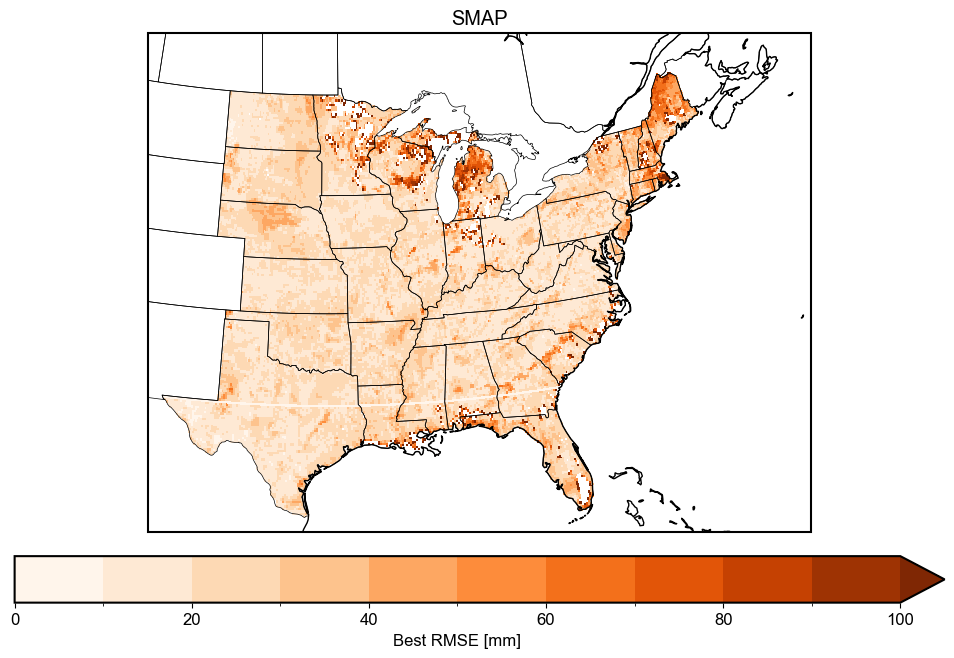

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'SMAP', 'pred_loss', '*', 'rmse', True, 'SMAP', ax)
plt.show()

In [6]:
get_jax_top('centralUS', 'VIC', 'pred_loss', '*')

epoch metric  train_loss  pred_loss  reg_loss  val_loss  awCap_sand  \
11     11   rmse     38.4691    38.3944   74.7719       NaN    4.672086   
11     11   rmse     43.2838    43.2396   44.1509       NaN         NaN   
11     11   rmse     38.0105    37.9490   61.4857       NaN    5.079199   
11     11   rmse     40.0088    39.6504  358.3948       NaN    6.901426   
11     11   rmse     36.6438    36.5763   67.4975       NaN    5.584042   

    awCap_loamy_sand  awCap_sandy_loam  awCap_silt_loam  ...  GS_start_wheat  \
11          4.362540          3.958590         4.680218  ...        4.236282   
11               NaN               NaN              NaN  ...        4.219495   
11          4.725865          4.548256         4.972938  ...        4.224705   
11          6.689266          6.237709         6.295331  ...        4.215579   
11          5.510591          5.147169         5.532009  ...        4.229037   

    GS_end_wheat  L_ini_wheat  L_dev_wheat  L_mid_wheat  Kc_ini_wheat  \
11      5.589465    -1.840063    -1.288346    -0.838119     -0.672564   
11      5.594881    -2.018614    -1.285210    -0.830679     -0.656568   
11      5.588746    -1.939130    -1.286746    -0.836403     -0.661535   
11      5.587768    -2.137921    -1.296706    -0.836807     -0.660716   
11      5.589669    -1.832286    -1.281818    -0.836749     -0.664834   

    Kc_mid_wheat  Kc_end_wheat  K_min_wheat  K_max_wheat  
11      0.239149     -0.910699    -0.648203     0.183276  
11      0.242771     -0.891474    -0.639735     0.187849  
11      0.238589     -0.893200    -0.643481     0.184636  
11      0.241568     -0.885272    -0.657008     0.175845  
11      0.239055     -0.900157    -0.642085     0.184968  

[5 rows x 103 columns]

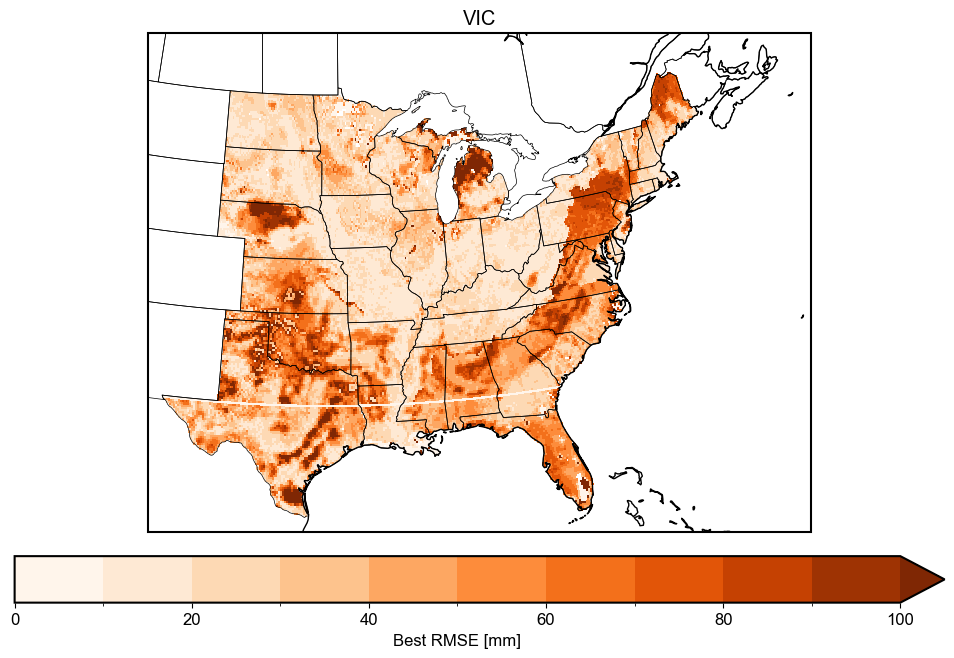

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'VIC', 'pred_loss', '59914r', 'rmse', True, 'VIC', ax)
plt.show()

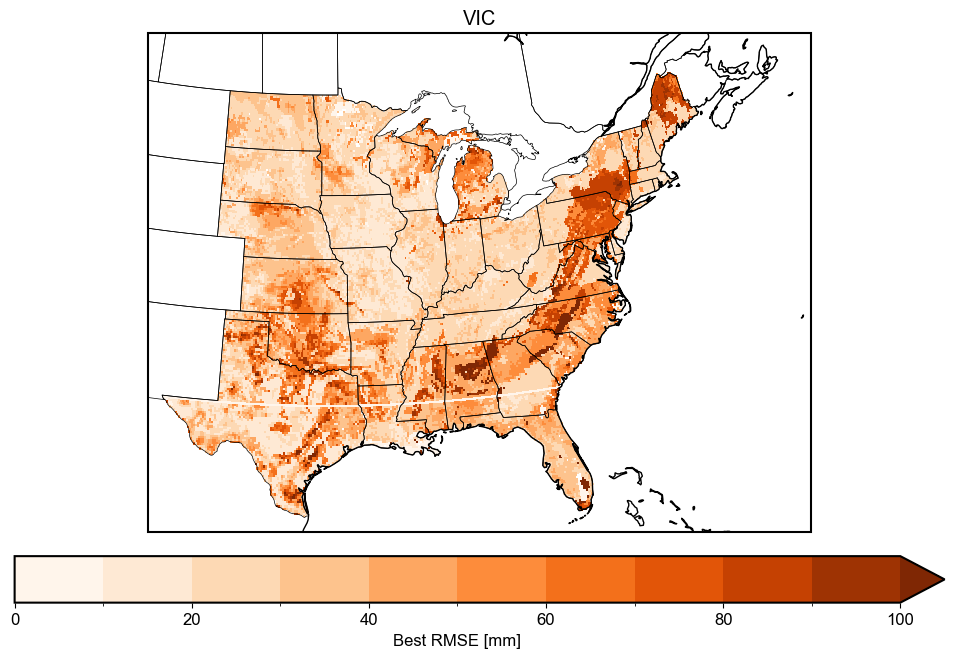

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'VIC', 'pred_loss', '*', 'rmse', True, 'VIC', ax)
plt.show()

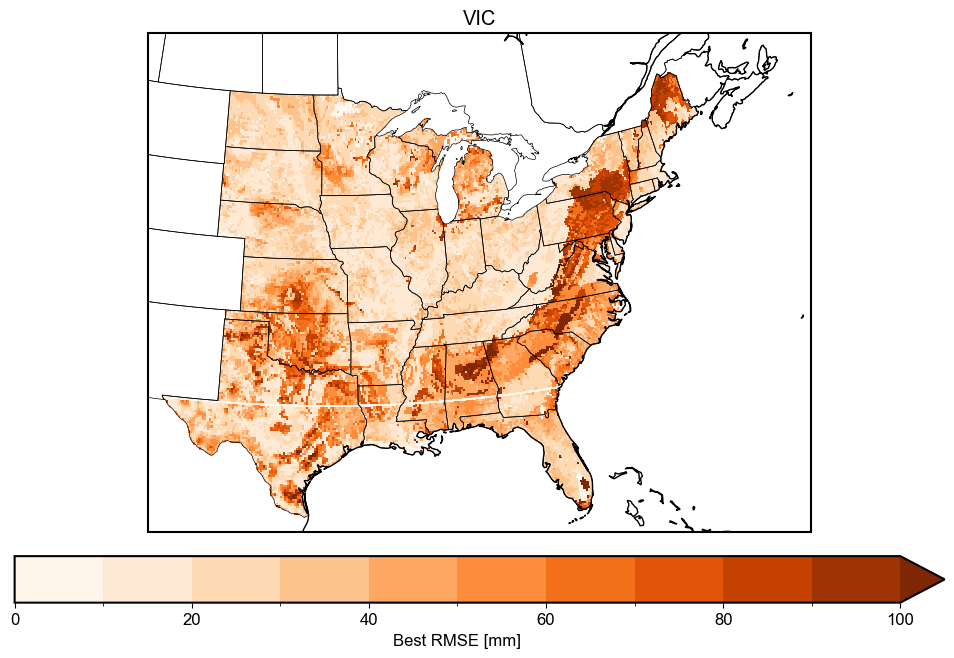

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'VIC', 'pred_loss', '*', 'rmse', True, 'VIC', ax)
plt.show()

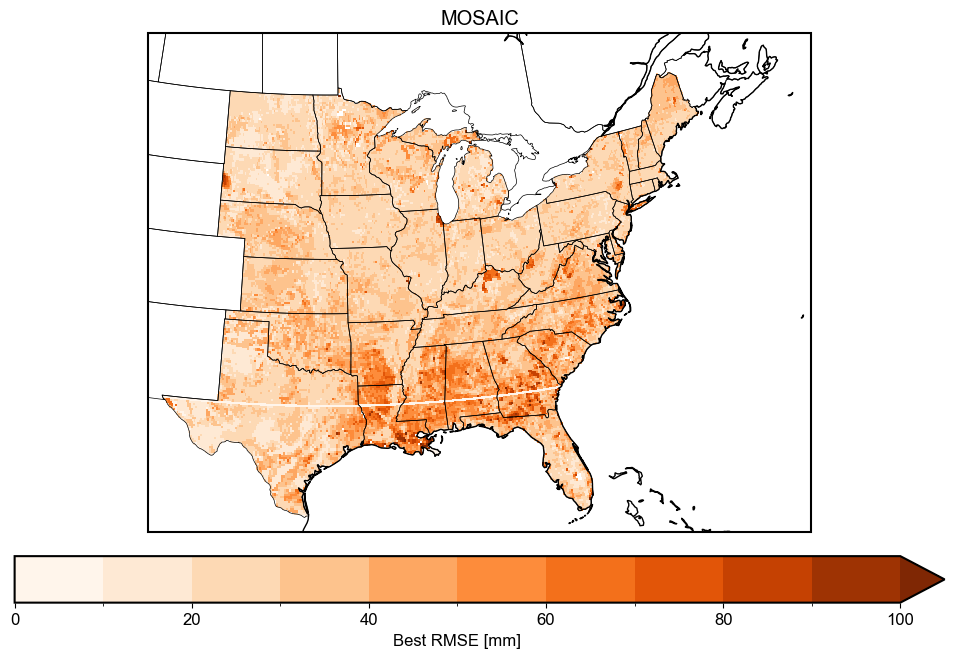

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'MOSAIC', 'pred_loss', '*', 'rmse', True, 'MOSAIC', ax)
plt.show()

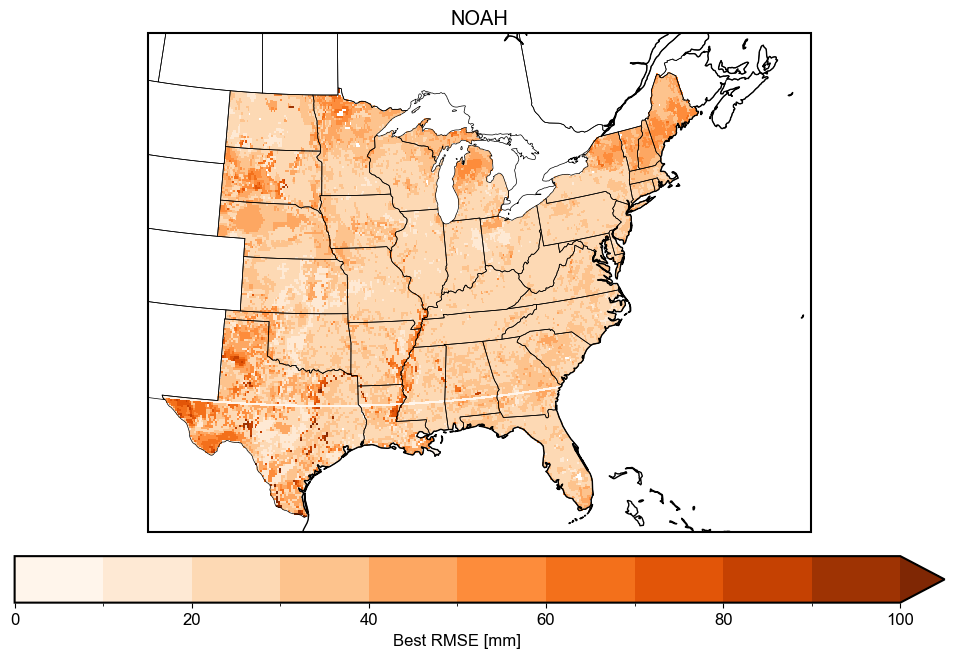

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))
plot_jax_map('centralUS', 'NOAH', 'pred_loss', '*', 'rmse', True, 'NOAH', ax)
plt.show()

In [8]:
def plot_jax_ts_all(subset_name, obs_name, lat, lon, metric, iden, title, legend, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()

    # Param names
    if obs_name == "VIC":
        param_names = param_names_vic
    else:
        param_names = param_names_main

    # Predictionf function
    if obs_name == "VIC":
        make_prediction = make_prediction_vic
    else:
        make_prediction = make_prediction_main
        
    # Read inputs 
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    # Get grid
    ds_grid = xr.open_dataset(f"{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/{obs_name}_validation.nc")
    lons = ds_grid.lon
    lats = ds_grid.lat
    nt = ys.shape[1]
    
    # Get correct idx
    idx_to_find = (find_nearest(lons, lon), find_nearest(lats, lat))
    shape_to_search = (x_maps.shape[0],)
    original_shape = (len(lons), len(lats))
    idx = np.unravel_index(np.ravel_multi_index(idx_to_find, original_shape), shape_to_search)[0]

    # Plot obs
    obs = ys[idx,:]
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    ax.plot(dates, obs, color='darkred', zorder=3, lw=2, label=obs_name)
    
    # Get top params
    df_params = get_jax_top(subset_name, obs_name, metric, iden)

    # Add info
    # Get best RMSE param
    theta_best_rmse = jnp.array([float(df_params.query("metric == 'rmse'").sort_values(by=metric).iloc[0][param]) for param in param_names])
    best_sim = make_prediction(theta_best_rmse, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])
    # ax.plot(dates, best_sim, color='silver', lw=3, zorder=2, alpha=0.8, label='Uncertainty bounds')
    ax.plot(dates, best_sim, color='gray', lw=2, zorder=2, label='Best parameter set')
    
    best_rmse = np.sqrt(np.mean((best_sim - obs)**2))
    best_corr = np.corrcoef(best_sim, obs)[0,1]

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.grid()
    if legend:
        ax.legend(ncols = 3, loc='lower right', columnspacing=1.)
    ax.set_title(title)
    ax.set_ylim([ax.get_ylim()[0],1.05*ax.get_ylim()[1]])
    ax.set_ylabel("Soil Moisture [mm]")
    ax.set_xlabel('')

In [9]:
dsc = xr.open_dataset('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/clayfrac_NLDASgrid.nc')
dss = xr.open_dataset('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/sandfrac_NLDASgrid.nc')
dsss = xr.open_dataset('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/siltfrac_NLDASgrid.nc')
ds_nldas = xr.open_dataset(f"{project_data_path}/WBM/geo_inputs/NLDAS_masks-veg-soil.nc4")

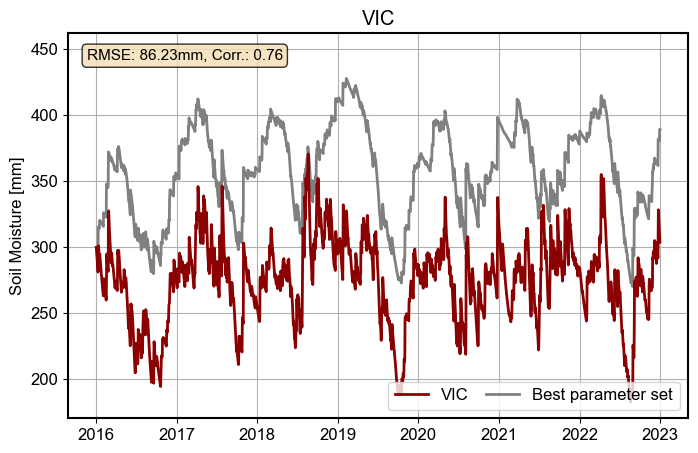

In [14]:
lat, lon = 42.18357544646681, -74.79841980556719

fig, ax = plt.subplots(figsize=(8,5))
plot_jax_ts_all('centralUS', 'VIC', lat, lon, 'pred_loss', '*', 'VIC', True, ax)
plt.show()

In [11]:
lat, lon = 42.18357544646681, -74.79841980556719
print(dsc.sel(lat=lat, lon=lon, method='nearest')['clayfrac'].values)
print(dss.sel(lat=lat, lon=lon, method='nearest')['sandfrac'].values)
print(dsss.sel(lat=lat, lon=lon, method='nearest')['siltfrac'].values)
print(ds_nldas.sel(lat=lat, lon=lon, method='nearest')['NLDAS_soil'].values)

13.585290908813262
38.04217529296815
48.37253189086838
[4.]


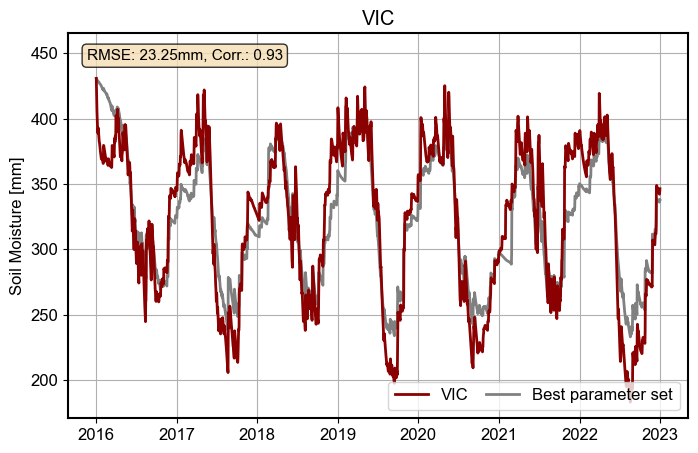

In [15]:
lat, lon = 40.401709414560266, -88.27655748085411

fig, ax = plt.subplots(figsize=(8,5))
plot_jax_ts_all('centralUS', 'VIC', lat, lon, 'pred_loss', '*', 'VIC', True, ax)
plt.show()

In [12]:
lat, lon = 40.401709414560266, -88.27655748085411
print(dsc.sel(lat=lat, lon=lon, method='nearest')['clayfrac'].values)
print(dss.sel(lat=lat, lon=lon, method='nearest')['sandfrac'].values)
print(dsss.sel(lat=lat, lon=lon, method='nearest')['siltfrac'].values)
print(ds_nldas.sel(lat=lat, lon=lon, method='nearest')['NLDAS_soil'].values)

35.22292327880805
13.090876579284464
51.604206085204275
[4.]


In [14]:
def plot_jax_ts_all(subset_name, obs_name, lat, lon, thresh, title, legend, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idx_to_find = (find_nearest(lons, lon), find_nearest(lats, lat))
    shape_to_search = (x_maps.shape[0],)
    original_shape = (len(lons), len(lats))
    idx = np.unravel_index(np.ravel_multi_index(idx_to_find, original_shape), shape_to_search)[0]

    # Plot obs
    obs = ys[idx,:]
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    ax.plot(dates, obs, color='darkred', zorder=3, lw=2, label=obs_name)
    
    # Get top
    df_top = get_jax_top(subset_name, obs_name, thresh)

    # Record count, corr, best RMSE, surprise index
    sim_all = []
    for index, row in df_top.iterrows():
        # Get params
        theta = jnp.array([row[param] for param in param_names])
            
        # Simulate
        sim = make_prediction(theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])

        # Plot
        ax.plot(dates, sim, color='silver', alpha=0.8, zorder=2)
        
        # Append for surpise index
        sim_all.append(sim)

    # Add info
    best_theta = jnp.array([df_top.sort_values(by='train_loss').iloc[0][param] for param in param_names])
    best_sim = make_prediction(best_theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])
    ax.plot(dates, best_sim, color='silver', lw=3, zorder=2, alpha=0.8, label='Uncertainty bounds')
    ax.plot(dates, best_sim, color='gray', lw=2, zorder=2, label='Best parameter set')
    
    best_rmse = np.sqrt(np.mean((best_sim - obs)**2))
    best_corr = np.corrcoef(best_sim, obs)[0,1]
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    coverage = 1 - ((((obs > maxs).sum() + (obs < mins).sum())) / len(obs))

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.text(x=0.77, y=0.96,
            s=f"Ensemble size: {str(len(df_top))}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.grid()
    if legend:
        ax.legend(ncols = 3, loc='lower right', columnspacing=1.)
    ax.set_title(title)
    ax.set_ylim([ax.get_ylim()[0],1.05*ax.get_ylim()[1]])
    ax.set_ylabel("Soil Moisture [mm]")
    ax.set_xlabel('')

### Simulate top results

In [11]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="10GiB",
    walltime="00:30:00"
)
cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

<Client: 'tcp://10.6.0.162:45459' processes=0 threads=0, memory=0 B>

In [26]:
def simulate_store_jax(subset_name, obs_name, theta, thresh, i):
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    spatial_vmap = jax.jit(jax.vmap(make_prediction, in_axes=(None, None, 0, 0, 0), out_axes=0))

    out = spatial_vmap(
        theta,
        constants,
        x_forcing_nt,
        x_forcing_nyrs,
        x_maps
        )

    # Construct xr 
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    nt = out.shape[1]

    ds_sim = xr.Dataset(
        data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(out.reshape(len(lons), len(lats), nt), (2,1,0)))),
        coords=dict(
            lon=lons,
            lat=lats,
            time=pd.date_range(start='01/01/2016', end='12/31/2022', periods=nt)))

    ds_sim.to_netcdf(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_out/{str(thresh)}thresh_{str(i)}.nc')

In [29]:
# Simulate all outputs to make reading easier
thresh = 1.01
subset_name = 'centralUS'

delayed = []

for obs_name in ['SMAP']:
# for obs_name in ['SMAP', 'VIC', 'MOSAIC', 'NOAH']:
    df_params = get_jax_top(subset_name, obs_name, thresh)
    for index, row in df_params.reset_index().iterrows():
        theta = jnp.array([row[param] for param in param_names])
        delayed.append(dask.delayed(simulate_store_jax)(subset_name, obs_name, theta, thresh, index))

# Compute
_ = dask.compute(*delayed)

## Plots

### Map plots

CPU times: user 3min 17s, sys: 3min 36s, total: 6min 54s
Wall time: 8min 39s


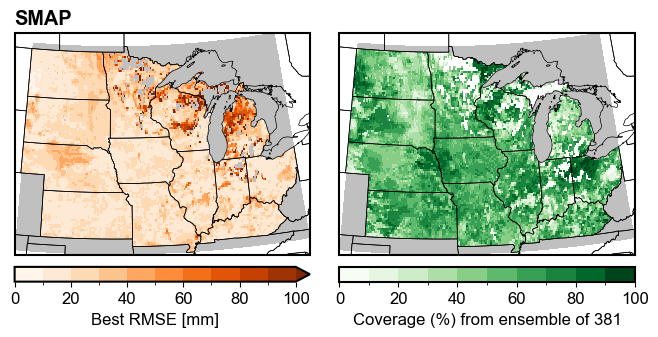

In [72]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'SMAP'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 4min 14s, sys: 4min 50s, total: 9min 4s
Wall time: 12min 36s


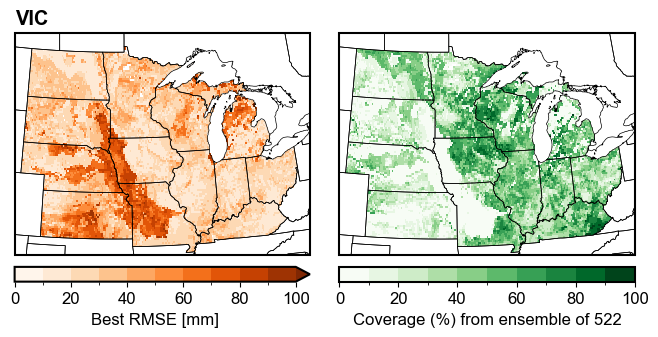

In [20]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'VIC'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 3min 38s, sys: 4min 8s, total: 7min 47s
Wall time: 10min 36s


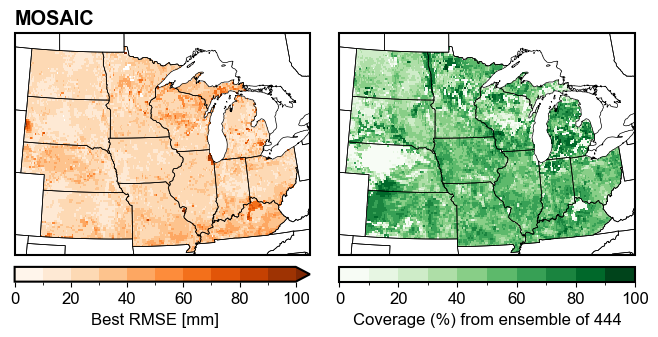

In [21]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'MOSAIC'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

CPU times: user 4min, sys: 4min 36s, total: 8min 37s
Wall time: 12min 35s


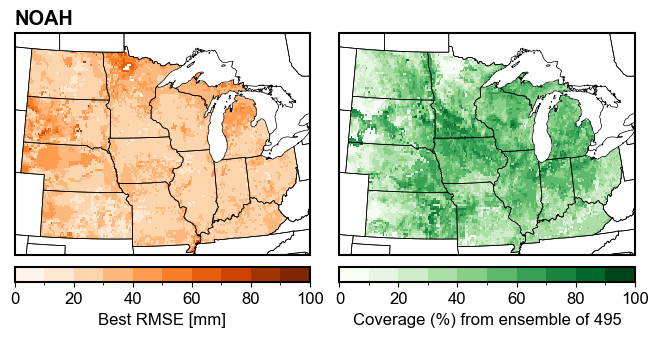

In [22]:
%%time
# Main plot: maps
subset_name = 'centralUS'
obs_name = 'NOAH'
thresh = 1.01

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True,
                        gridspec_kw=dict(wspace=0.1, hspace=0.2),
                        subplot_kw=dict(projection=ccrs.LambertConformal()))

plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='rmse', cbar=True, title='', ax=axs[0])
plot_jax_map(subset_name=subset_name, obs_name=obs_name, thresh=thresh, plot_type='coverage', cbar=True, title='', ax=axs[1])

axs[0].set_title(obs_name, loc='left', fontdict={'fontweight': 'bold'})

plt.savefig(f'../figs/JAX_{obs_name}_map.png', dpi=600)

### Timeseries plots

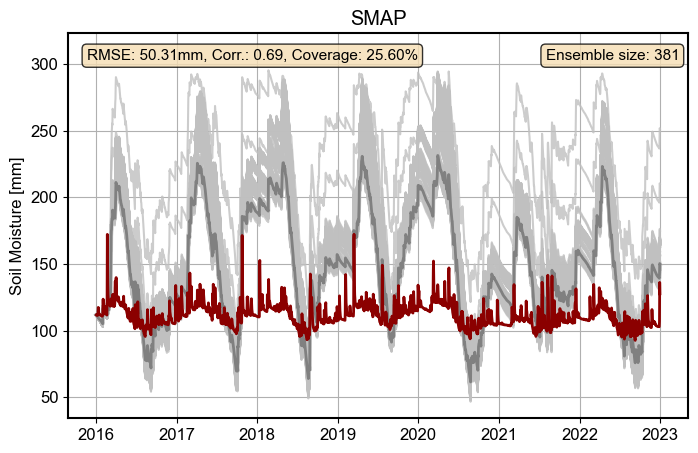

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 44.19937771706298, -85.55068009153037

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name}",
                ax=ax)

plt.show()

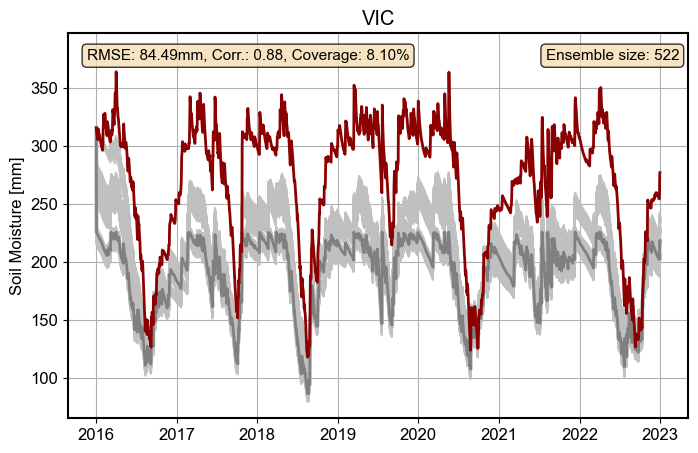

In [23]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 44.19937771706298, -85.55068009153037

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name}",
                ax=ax)

plt.show()

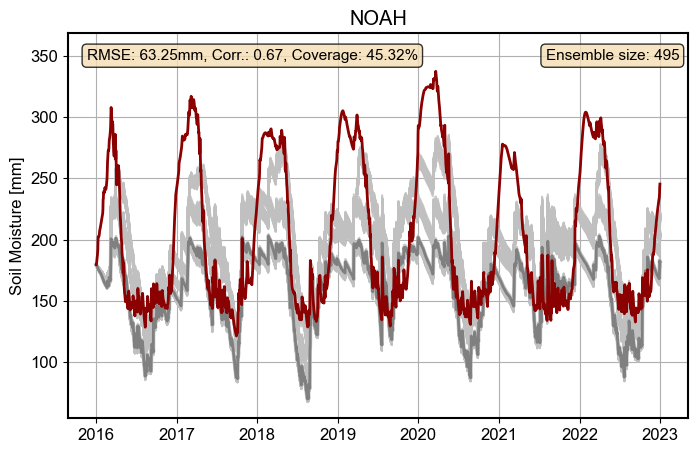

In [25]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'NOAH'

lat, lon = 44.19937771706298, -85.55068009153037

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name}",
                ax=ax)

plt.show()

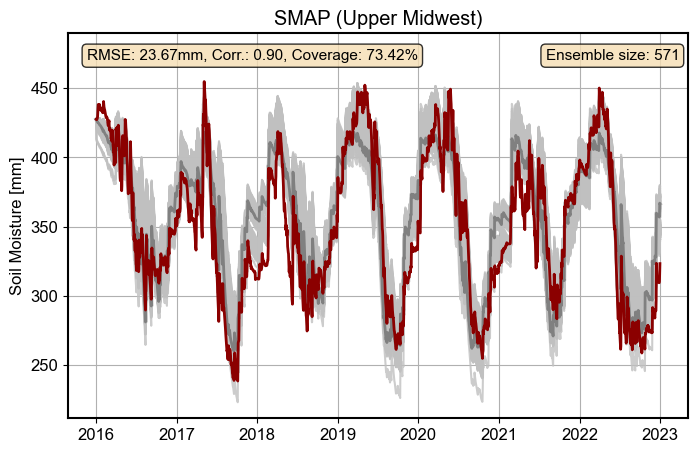

In [33]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 39.96077694862997, -88.44932637651797 # Illinois

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Midwest)",
                ax=ax)

plt.show()

In [34]:
lat, lon = 39.96077694862997, -88.44932637651797

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values * 0.9}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values * 1.2}")

awCap: 275.6699890136719
wiltingp: 231.48001098632812


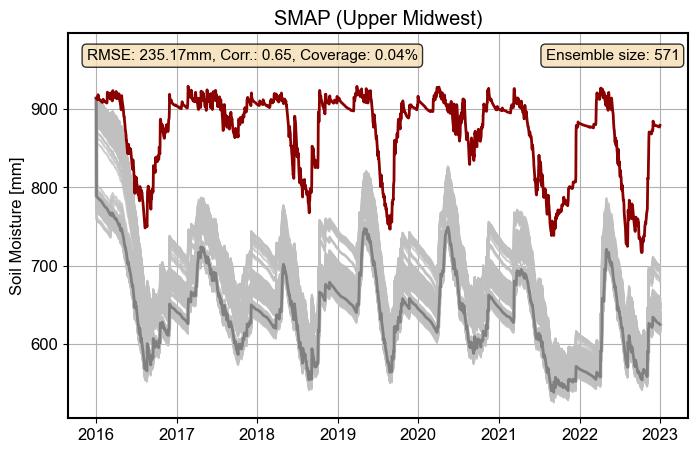

In [12]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 45.660126978388895, -87.641380949398 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

plt.show()

In [22]:
smap_awCap = xr.open_dataset("/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/SMAP_awCap.nc")
smap_wiltingp = xr.open_dataset("/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/geo_inputs/SMAP_wiltingp.nc")

In [35]:
lat, lon = 45.660126978388895, -87.641380949398

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values}")

awCap: 588.5
wiltingp: 341.5


In [36]:
lat, lon = 45.660126978388895, -87.641380949398

print(f"awCap: {smap_awCap.sel(lat=lat, lon=lon, method='nearest').awCap.values * 0.85}")
print(f"wiltingp: {smap_wiltingp.sel(lat=lat, lon=lon, method='nearest').wiltingp.values * 1.2}")

awCap: 500.22499999999997
wiltingp: 409.8


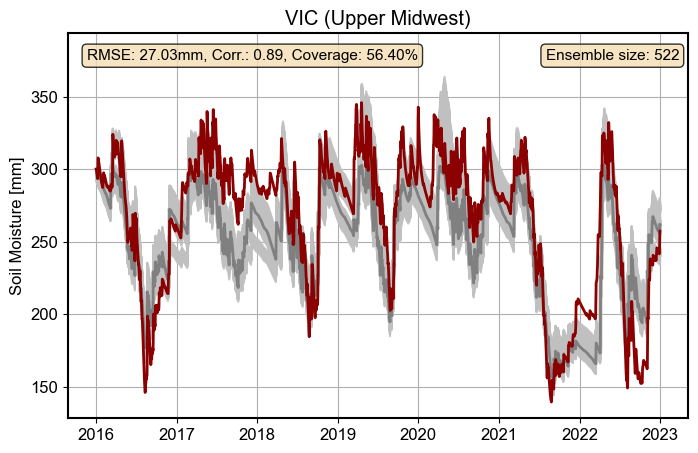

In [31]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 45.660126978388895, -87.641380949398 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

plt.show()

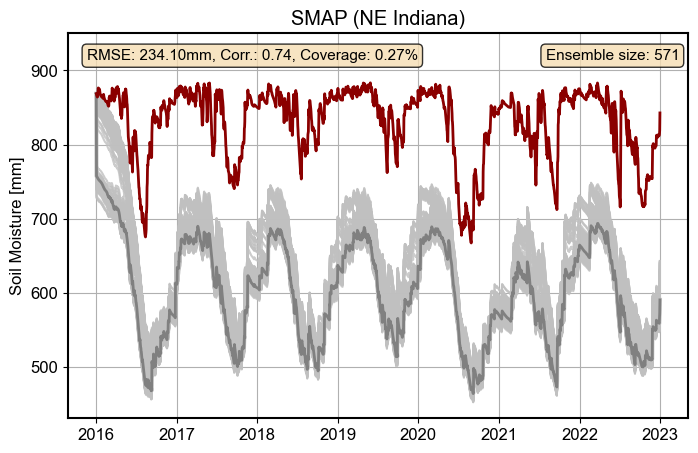

In [38]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'SMAP'

lat, lon = 41.21712676021884, -85.0522563937162 # NE Indiana

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (NE Indiana)",
                ax=ax)

plt.show()

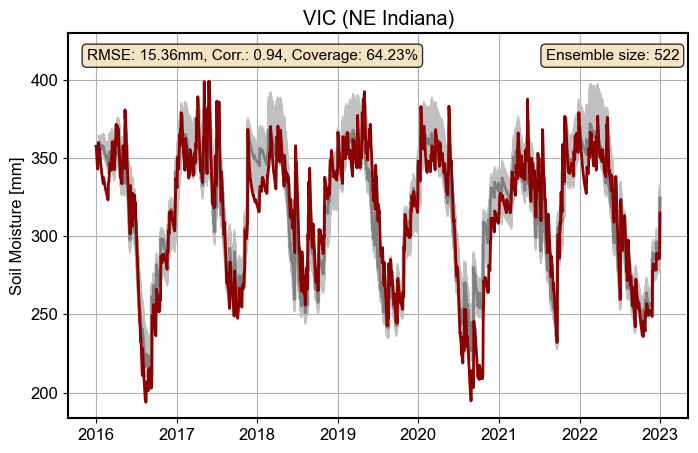

In [32]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 41.21712676021884, -85.0522563937162 # NE Indiana

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (NE Indiana)",
                ax=ax)

plt.show()

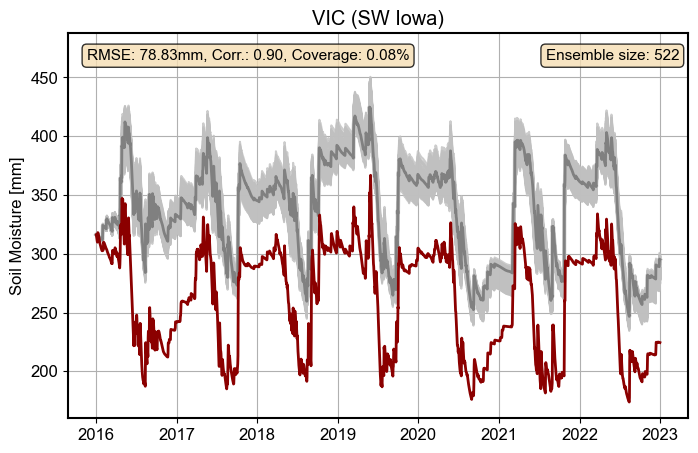

In [39]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 40.76063537671462, -95.39930528494172 # SW Iowa

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (SW Iowa)",
                ax=ax)

plt.show()

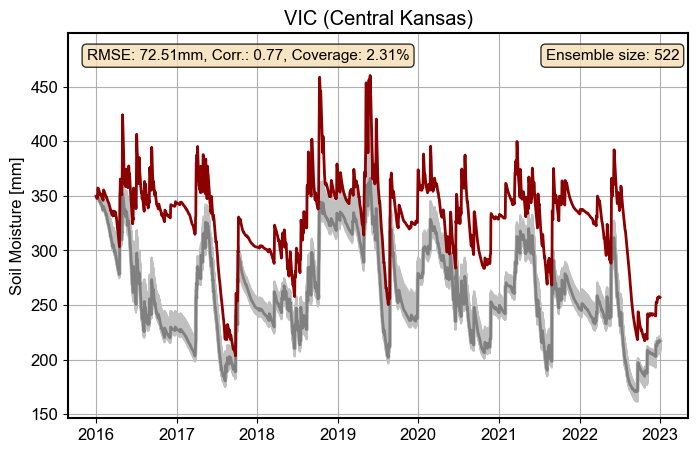

In [40]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'VIC'

lat, lon = 38.504984973848856, -98.3657123416093 # central KS

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Kansas)",
                ax=ax)

plt.show()

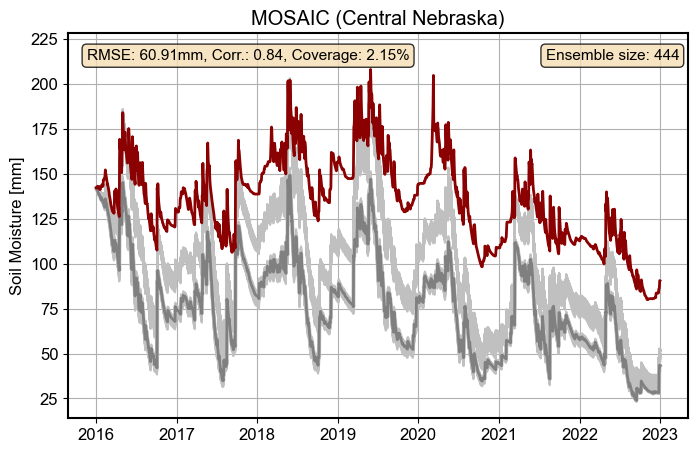

In [42]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'MOSAIC'

lat, lon = 41.86969145376092, -100.97115781699968 # central NE

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                thresh=1.01,
                legend=False,
                title=f"{obs_name} (Central Nebraska)",
                ax=ax)

plt.show()

### Parameters

In [28]:
def get_jax_top(subset_name, obs_name, metric, iden):
    # Loop through files
    files = glob(f'{project_data_path}/WBM/calibration/{subset_name}/{obs_name}/training_res/*{iden}*.txt')

    # Record count, corr, best RMSE, surprise index
    df_out = []
    for file in files:
        # Read
        # columns = ['epoch', 'metric', 'train_loss', 'pred_loss', 'reg_loss', 'val_loss'] + param_names
        df = pd.read_csv(file, sep = ' ') #, names = columns).iloc[1:]
        
        # Take best val
        df_best = df.sort_values(by=metric).iloc[:1]
        df_out.append(df_best)

    # Join and return
    df_out = pd.concat(df_out)
    return df_out

In [32]:
def plot_jax_ts_all(subset_name, obs_name, lat, lon, iden, metric, loss, title, legend, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
    
    # Get simulation output
    ys, x_forcing_nt, x_forcing_nyrs, x_maps = read_inputs(subset_name, obs_name, False)
    
    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idx_to_find = (find_nearest(lons, lon), find_nearest(lats, lat))
    shape_to_search = (x_maps.shape[0],)
    original_shape = (len(lons), len(lats))
    idx = np.unravel_index(np.ravel_multi_index(idx_to_find, original_shape), shape_to_search)[0]

    # Plot obs
    obs = ys[idx,:]
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    ax.plot(dates, obs, color='darkred', zorder=3, lw=2, label=obs_name)
    
    # Get top
    df_top = get_jax_top(subset_name, obs_name, loss, iden).dropna() #.query(f'metric == "{metric}"')

    # Record count, corr, best RMSE, surprise index
    sim_all = []
    for index, row in df_top.iterrows():
        # Get params
        theta = jnp.array([row[param] for param in param_names])
            
        # Simulate
        sim = make_prediction(theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])

        # Plot
        ax.plot(dates, sim, color='silver', alpha=0.8, zorder=2)
        
        # Append for surpise index
        sim_all.append(sim)

    # Add info
    best_theta = jnp.array([df_top.sort_values(by='train_loss').iloc[0][param] for param in param_names])
    best_sim = make_prediction(best_theta, constants, x_forcing_nt[idx,:,:], x_forcing_nyrs[idx,:], x_maps[idx,:])
    ax.plot(dates, best_sim, color='silver', lw=3, zorder=2, alpha=0.8, label='Uncertainty bounds')
    ax.plot(dates, best_sim, color='gray', lw=2, zorder=2, label='Best parameter set')
    
    best_rmse = np.sqrt(np.mean((best_sim - obs)**2))
    best_corr = np.corrcoef(best_sim, obs)[0,1]
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    coverage = 1 - ((((obs > maxs).sum() + (obs < mins).sum())) / len(obs))

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.text(x=0.77, y=0.96,
            s=f"Ensemble size: {str(len(df_top))}",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=11)
    
    ax.grid()
    if legend:
        ax.legend(ncols = 3, loc='lower right', columnspacing=1.)
    ax.set_title(title)
    ax.set_ylim([ax.get_ylim()[0],1.05*ax.get_ylim()[1]])
    ax.set_ylabel("Soil Moisture [mm]")
    ax.set_xlabel('')

/tmp/ipykernel_1893434/2056495989.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)


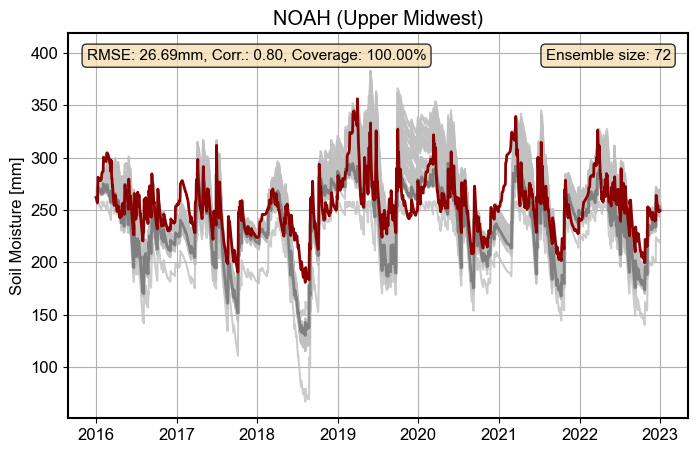

In [60]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'NOAH'

lat, lon = 40.038722179721155, -92.82082050711176 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                iden = 'RANDOM_PARAMS',
                loss = 'val_loss',
                metric = 'rmse',
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

# plot_jax_ts_all(subset_name=subset_name,
#                 obs_name=obs_name,
#                 lat=lat,
#                 lon=lon,
#                 iden = 'RANDOM_PARAMS',
#                 loss = 'val_loss',
#                 metric = 'q0-25rmse',
#                 legend=False,
#                 title=f"{obs_name} (Upper Midwest)",
#                 ax=ax)

plt.show()

/tmp/ipykernel_1893434/2056495989.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)


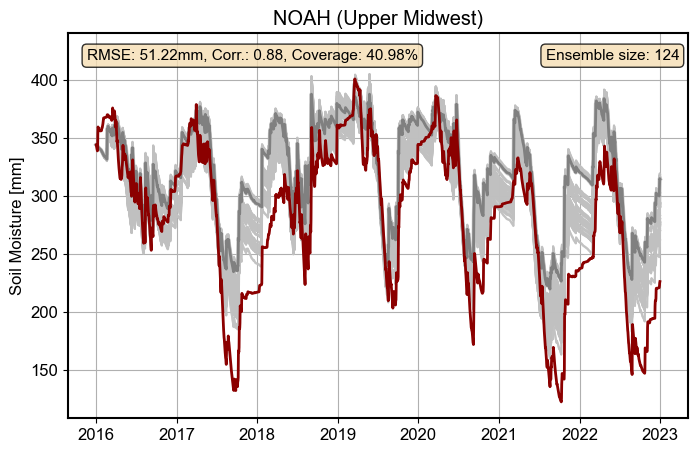

In [34]:
fig, ax = plt.subplots(figsize=(8,5))

subset_name = 'centralUS'
obs_name = 'NOAH'

lat, lon = 42.038722179721155, -92.82082050711176 # upper Midwest

plot_jax_ts_all(subset_name=subset_name,
                obs_name=obs_name,
                lat=lat,
                lon=lon,
                iden = 'INITIAL_PARAMS',
                loss = 'val_loss',
                metric = 'rmse',
                legend=False,
                title=f"{obs_name} (Upper Midwest)",
                ax=ax)

# plot_jax_ts_all(subset_name=subset_name,
#                 obs_name=obs_name,
#                 lat=lat,
#                 lon=lon,
#                 iden = 'RANDOM_PARAMS',
#                 loss = 'val_loss',
#                 metric = 'q0-25rmse',
#                 legend=False,
#                 title=f"{obs_name} (Upper Midwest)",
#                 ax=ax)

plt.show()

In [29]:
get_jax_top('centralUS', 'NOAH', 'val_loss', '32batchsize_*_INITIAL_PARAMS').query('metric == "rmse"')

/tmp/ipykernel_1893434/2056495989.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)


epoch metric  train_loss  pred_loss  reg_loss  val_loss  awCap_scalar  \
20    21   rmse     29.8472    29.7858   61.4050   30.0072     -0.273630   
20    21   rmse     29.9095    29.8451   64.3429   29.7836     -0.266453   
20    21   rmse     29.9204    29.8594   60.9340   29.7345     -0.266598   
19    20   rmse     29.9031    29.8419   61.2140   29.8615     -0.273149   
19    20   rmse     29.9231    29.8613   61.8258   29.7817     -0.271278   

    wiltingp_scalar  alpha_claycoef  alpha_sandcoef  ...  GS_start_wheat  \
20         0.450557       -4.102482       -4.407416  ...        4.955517   
20         0.438866       -4.085992       -4.395603  ...        4.956618   
20         0.443198       -4.081390       -4.398967  ...        4.960814   
19         0.441180       -3.944576       -4.260128  ...        4.962222   
19         0.441612       -3.947618       -4.260633  ...        4.962428   

    GS_end_wheat  L_ini_wheat  L_dev_wheat  L_mid_wheat  Kc_ini_wheat  \
20      5.379703    -1.875773    -1.670625    -1.117975     -1.324329   
20      5.377554    -1.884854    -1.669259    -1.117876     -1.324349   
20      5.381697    -1.873894    -1.667830    -1.117213     -1.328999   
19      5.381034    -1.843450    -1.672576    -1.121158     -1.335568   
19      5.377613    -1.848644    -1.669736    -1.118588     -1.337971   

    Kc_mid_wheat  Kc_end_wheat  K_min_wheat  K_max_wheat  
20      0.026422     -1.903361    -1.515395     0.021165  
20      0.024392     -1.903406    -1.514640     0.020240  
20      0.028979     -1.905966    -1.516424     0.022193  
19      0.026860     -1.903150    -1.512502     0.023499  
19      0.026148     -1.911959    -1.515822     0.019415  

[5 rows x 75 columns]

In [52]:
pd.read_csv('/storage/group/pches/default/users/dcl5300/wbm_soilM_crop_uc_lafferty-etal-2024-tbd_DATA/WBM/calibration/centralUS/NOAH/training_res/q0-25rmse_20epochs_32batchsize_adam-opt_9482val_0.001reg_-1500r_RANDOM_PARAMS.txt', sep=' ')

epoch     metric  train_loss  pred_loss  reg_loss  val_loss  awCap_scalar  \
0       1  q0-25rmse     59.4161    59.3423   73.8229   36.7703     -1.807696   
1       2  q0-25rmse     23.7548    23.6927   62.1623   13.4007     -1.948581   
2       3  q0-25rmse      9.2055     9.1527   52.7305    6.9752     -1.963315   
3       4  q0-25rmse      7.3876     7.3182   69.3434    7.5538     -1.805237   
4       5  q0-25rmse      9.6611     9.5797   81.3161   11.4341     -1.472567   
5       6  q0-25rmse     16.6226    16.5870   35.6479   21.4130     -1.009557   
6       7  q0-25rmse     22.4710    22.4395   31.4432   20.8356     -0.564114   
7       8  q0-25rmse     19.9430    19.8979   45.0278   19.0129     -0.400574   
8       9  q0-25rmse     18.8125    18.7634   49.0870   18.3229     -0.340613   
9      10  q0-25rmse     18.3086    18.2596   48.9098   17.9828     -0.311663   
10     11  q0-25rmse     18.0277    17.9758   51.8392   17.7815     -0.292880   
11     12  q0-25rmse     17.8502    17.7948   55.3797   17.6507     -0.278805   
12     13  q0-25rmse     17.7282    17.6631   65.0677   17.5521     -0.272464   
13     14  q0-25rmse     17.6404    17.5824   57.9774   17.4844     -0.266299   
14     15  q0-25rmse     17.5722    17.5218   50.3499   17.4461     -0.259419   
15     16  q0-25rmse     17.5182    17.4718   46.4269   17.3967     -0.262875   
16     17  q0-25rmse     17.4777    17.4243   53.3932   17.3550     -0.259568   
17     18  q0-25rmse     17.4383    17.3908   47.5588   17.3288     -0.259312   
18     19  q0-25rmse     17.4098    17.3595   50.2918   17.3030     -0.256065   
19     20  q0-25rmse     17.3879    17.3329   55.0385   17.2751     -0.260950   
20     21  q0-25rmse     17.3608    17.3148   46.0204   17.2680     -0.259968   

    wiltingp_scalar  alpha_claycoef  alpha_sandcoef  ...  GS_start_wheat  \
0          1.127266        1.812289        1.446144  ...        4.615110   
1          0.880954        1.997657        1.551516  ...        4.647012   
2          0.728711        2.061556        1.500476  ...        4.817133   
3          0.676392        1.965538        1.235776  ...        4.915477   
4          0.665121        1.728701        0.835689  ...        4.953501   
5          0.671154        1.448803        0.351664  ...        4.963584   
6          0.649590        1.221232       -0.124518  ...        4.888135   
7          0.560666        1.127428       -0.443896  ...        4.914084   
8          0.493016        0.952971       -0.705557  ...        4.957054   
9          0.444271        0.755288       -0.939785  ...        4.959392   
10         0.409158        0.559840       -1.153397  ...        4.952897   
11         0.384934        0.373587       -1.352323  ...        4.964740   
12         0.364247        0.206288       -1.537956  ...        4.951053   
13         0.350936        0.045197       -1.716164  ...        4.965357   
14         0.342711       -0.106788       -1.887861  ...        4.964749   
15         0.332252       -0.247277       -2.050196  ...        4.953227   
16         0.325899       -0.384222       -2.210324  ...        4.958818   
17         0.320919       -0.515417       -2.365608  ...        4.952203   
18         0.319605       -0.646062       -2.519863  ...        4.964143   
19         0.313661       -0.769875       -2.669920  ...        4.959084   
20         0.307312       -0.889877       -2.819006  ...        4.955419   

    GS_end_wheat  L_ini_wheat  L_dev_wheat  L_mid_wheat  Kc_ini_wheat  \
0       5.598225    -1.676001    -1.266849    -0.831068     -1.323085   
1       5.597243    -1.676340    -1.253282    -0.832263     -1.217559   
2       5.586079    -1.692822    -1.275501    -0.856660     -1.158988   
3       5.581883    -1.694462    -1.280547    -0.876536     -1.174678   
4       5.586210    -1.672045    -1.264204    -0.889878     -1.280961   
5       5.582630    -1.665711    -1.262796    -0.905075     -1.384558   
6       5.593464    -1.703925    -1.2

In [51]:
get_jax_top('centralUS', 'NOAH', 'val_loss', 'RANDOM').query('metric == "q0-25rmse"').dropna()

/tmp/ipykernel_1893434/2056495989.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)


epoch     metric  train_loss  pred_loss  reg_loss  val_loss  awCap_scalar  \
20    21  q0-25rmse     17.3749    17.3257   49.2505   17.2739     -0.250443   
20    21  q0-25rmse     16.9586    16.9133   45.2979   16.8356     -0.086696   
20    21  q0-25rmse     16.2720    16.2057   66.2380   16.1505      0.130732   
20    21  q0-25rmse     16.5429    16.4883   54.6697   16.3628      0.069240   
20    21  q0-25rmse     17.0514    16.9947   56.7103   17.1145     -0.212041   
20    21  q0-25rmse     16.8901    16.8336   56.4645   16.9212     -0.122629   
20    21  q0-25rmse     17.0349    16.9338  101.0355   17.0556     -0.118656   
20    21  q0-25rmse     16.0007    15.9447   55.9577   16.1571      0.281342   
20    21  q0-25rmse     16.4859    16.4271   58.7856   16.3149      0.036647   
20    21  q0-25rmse     16.3273    16.2782   49.0763   16.1934      0.036234   
20    21  q0-25rmse     17.2044    17.1667   37.6667   17.0879     -0.051816   
20    21  q0-25rmse     16.5204    16.4625   57.9193   16.3809      0.135330   
20    21  q0-25rmse     16.5604    16.5080   52.3989   16.4756     -0.022284   
20    21  q0-25rmse     17.0528    17.0064   46.4672   16.9841     -0.152598   
20    21  q0-25rmse     16.7778    16.7177   60.1774   16.6759     -0.019108   
20    21  q0-25rmse     17.5893    17.5444   44.8333   17.5506     -0.255396   
20    21  q0-25rmse     16.4344    16.3812   53.1716   16.3559      0.090180   
20    21  q0-25rmse     16.2527    16.1970   55.6267   16.1576      0.138073   
2      3  q0-25rmse      9.2055     9.1527   52.7305    6.9752     -1.963315   
20    21  q0-25rmse     16.9765    16.9291   47.4277   16.8923     -0.093285   

    wiltingp_scalar  alpha_claycoef  alpha_sandcoef  ...  GS_start_wheat  \
20         0.322389       -5.222985       -2.765535  ...        4.961139   
20         0.269066       -5.183556       -1.780800  ...        4.934656   
20         0.153108       -4.986815       -5.617488  ...        4.925764   
20         0.191858        0.330609       -3.941359  ...        4.943762   
20         0.269880       -5.018380       -5.676786  ...        4.956228   
20         0.248884       -0.504571       -2.907999  ...        4.266702   
20         0.273511       -1.555416       -2.795942  ...        4.438875   
20         0.108170       -4.749404       -4.257525  ...        4.891691   
20         0.157373       -2.971405       -1.913926  ...        4.896647   
20         0.144910       -4.886000       -4.989754  ...        4.914942   
20         0.283496       -3.591020       -0.753552  ...        4.346144   
20         0.187665       -5.014039       -1.573872  ...        4.569473   
20         0.195066       -1.546014       -5.652119  ...        4.934249   
20         0.254397       -5.099466       -1.679911  ...        4.290846   
20         0.185543       -4.864707       -0.949797  ...        4.348238   
20         0.319023       -4.648796       -0.845061  ...        4.265001   
20         0.153925       -4.615615       -3.044286  ...        4.902436   
20         0.142461       -4.928953       -5.613840  ...        4.913617   
2          0.728711        2.061556        1.500476  ...        4.817133   
20         0.270452       -1.065267       -1.854650  ...        4.926995   

    GS_end_wheat  L_ini_wheat  L_dev_wheat  L_mid_wheat  Kc_ini_wheat  \
20      5.386496    -1.720505    -1.523510    -1.091011     -1.316623   
20      5.399006    -1.738040    -1.378470    -1.027170     -1.234225   
20      5.409543    -2.002437    -1.481970    -1.026383     -1.195966   
20      5.396440    -1.727471    -1.432856    -1.054508     -1.271405   
20      5.389429    -1.724176    -1.466438    -1.078567     -1.304160   
20      5.387762    -2.533406    -1.705180    -1.103539     -0.712579   
20      5.407193    -2.313357    -1.891114    -1.058210     -1.093055   
20      5.438045    -1.752245    -1.335889    -0.941851     -1.186520   
20      5.431078    -1.749025    -1.341150    -0.968244     -1.18161

In [71]:
get_jax_top('centralUS', 'NOAH', 'val_loss', '64batchsize').query('metric == "rmse"')

/tmp/ipykernel_2315112/2056495989.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)


epoch metric  train_loss  pred_loss  reg_loss  val_loss  awCap_scalar  \
20    21   rmse     30.2131    30.1537   59.3916   30.2930     -0.305680   
20    21   rmse     30.2512    30.1945   56.7730   30.1691     -0.295701   
20    21   rmse     30.2789    30.2221   56.7942   30.0775     -0.303679   
20    21   rmse     30.2509    30.1937   57.1502   30.2007     -0.299876   
20    21   rmse     30.2663    30.2083   57.9971   30.1255     -0.297406   

    wiltingp_scalar  alpha_claycoef  alpha_sandcoef  ...  GS_start_wheat  \
20         0.432371       -2.640083       -2.898351  ...        4.972543   
20         0.428402       -2.638488       -2.901909  ...        4.967365   
20         0.424641       -2.645716       -2.903440  ...        4.968659   
20         0.427360       -2.636642       -2.899445  ...        4.970399   
20         0.426849       -2.644113       -2.902697  ...        4.969036   

    GS_end_wheat  L_ini_wheat  L_dev_wheat  L_mid_wheat  Kc_ini_wheat  \
20      5.379390    -1.756196    -1.684870    -1.129610     -1.375769   
20      5.379571    -1.778018    -1.682524    -1.123806     -1.367002   
20      5.381495    -1.775020    -1.687189    -1.124103     -1.372826   
20      5.379183    -1.761394    -1.681445    -1.125469     -1.374681   
20      5.383386    -1.756822    -1.684365    -1.124466     -1.376997   

    Kc_mid_wheat  Kc_end_wheat  K_min_wheat  K_max_wheat  
20      0.024670     -1.935993    -1.523241     0.020820  
20      0.025717     -1.931748    -1.518791     0.019729  
20      0.027549     -1.938692    -1.518558     0.023250  
20      0.024175     -1.930694    -1.520068     0.019471  
20      0.029614     -1.939210    -1.518492     0.024768  

[5 rows x 75 columns]

In [27]:
def plot_params(subset_name, obs_name, thresh, metric, params, axs):
    # Read top params
    df_params = get_jax_top(subset_name, obs_name, metric, thresh)

    # Metrics
    # metrics = ['rmse', 'mse', 'kge', 'q0-25rmse', 'q75-100rmse']
    metrics = ['rmse', 'kge', 'q0-25rmse', 'q75-100rmse']
    # Plot
    for ix, param in enumerate(params):
        ax=axs[ix]
        ax.set_title(param)
        for metric in metrics:
            np.exp(df_params[df_params['metric'] == metric][param]).plot.kde(label=metric, ax=ax, lw=2)
        if ax.get_xlim()[0] < 0:
            ax.set_xlim([0, ax.get_xlim()[1]])
        ax.grid()
        ax.set_yticklabels([])
        ax.set_ylabel('')

/tmp/ipykernel_2315112/498052357.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)
/tmp/ipykernel_2315112/498052357.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_out = pd.concat(df_out)
/tmp/ipykernel_2315112/498052357.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior

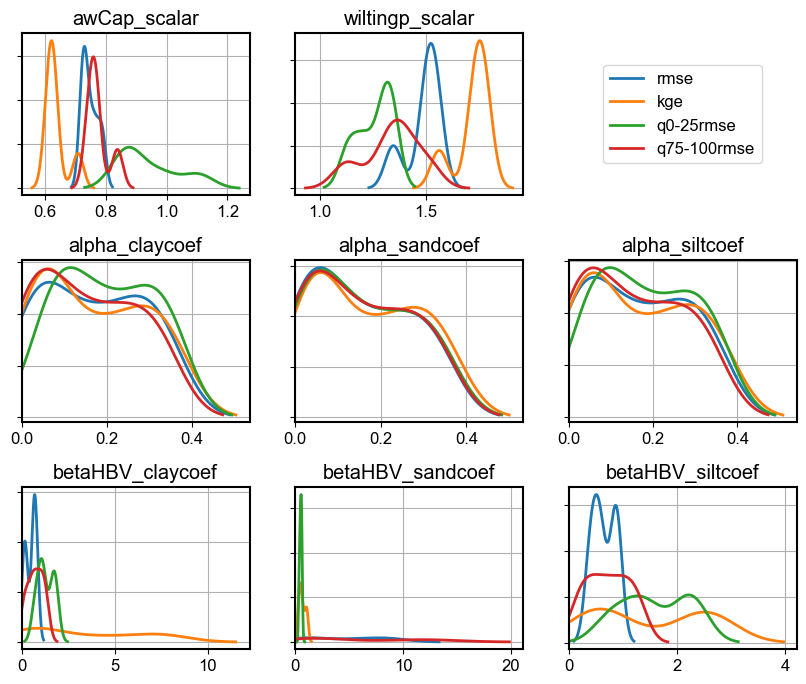

In [28]:
subset_name = 'centralUS'
obs_name = 'NOAH'
thresh = 1.0

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, 'val_loss', ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, 'val_loss', ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, 'val_loss', ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

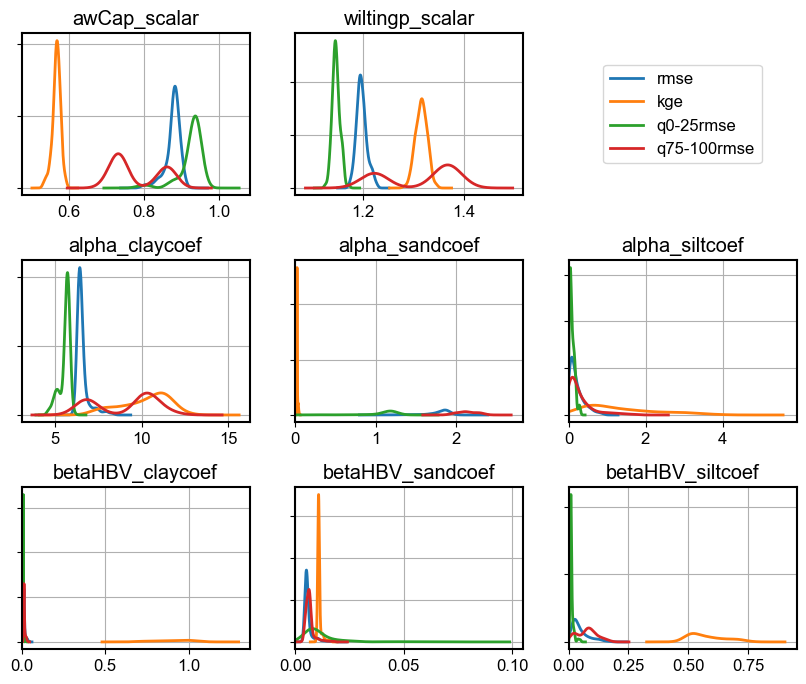

In [75]:
subset_name = 'centralUS'
obs_name = 'SMAP'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

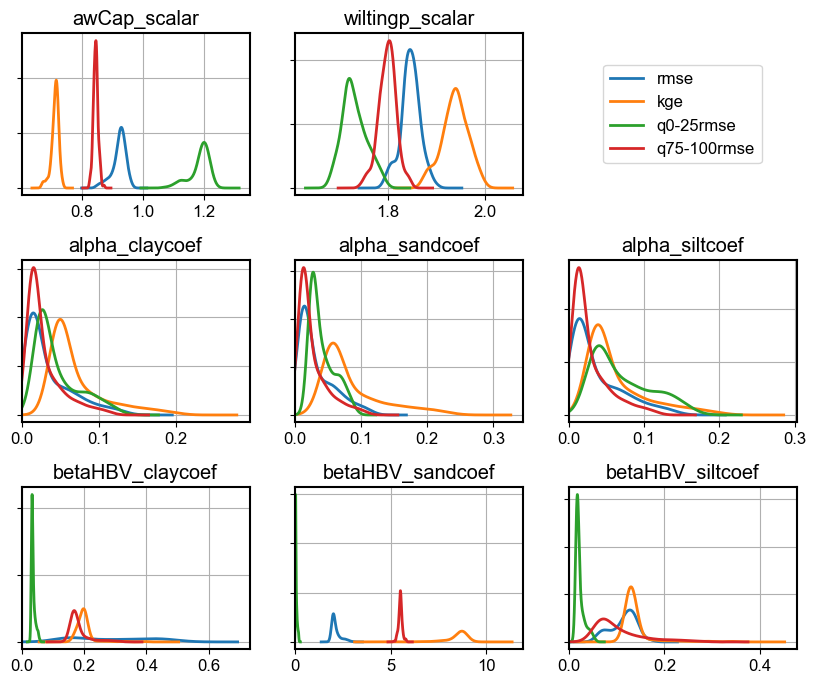

In [76]:
subset_name = 'centralUS'
obs_name = 'VIC'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

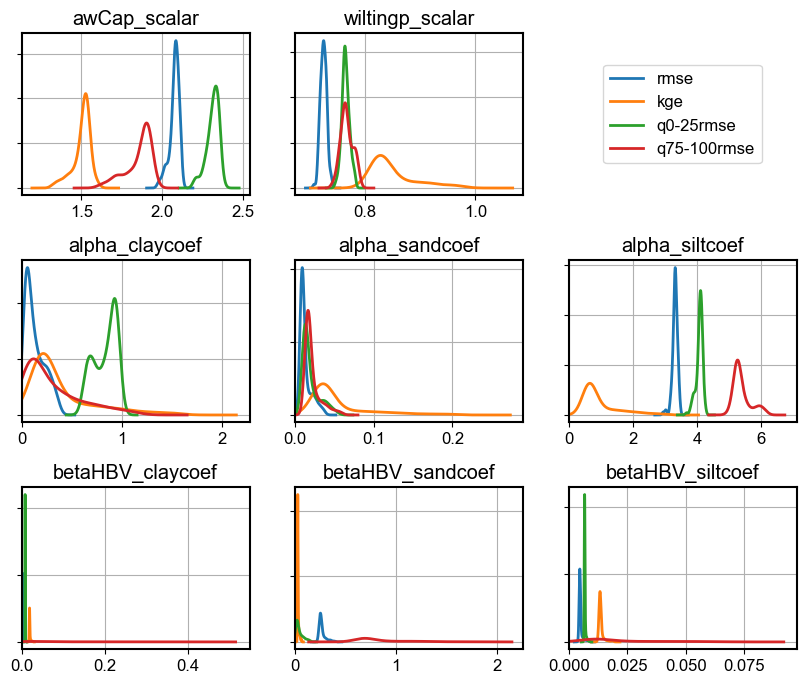

In [69]:
subset_name = 'centralUS'
obs_name = 'MOSAIC'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

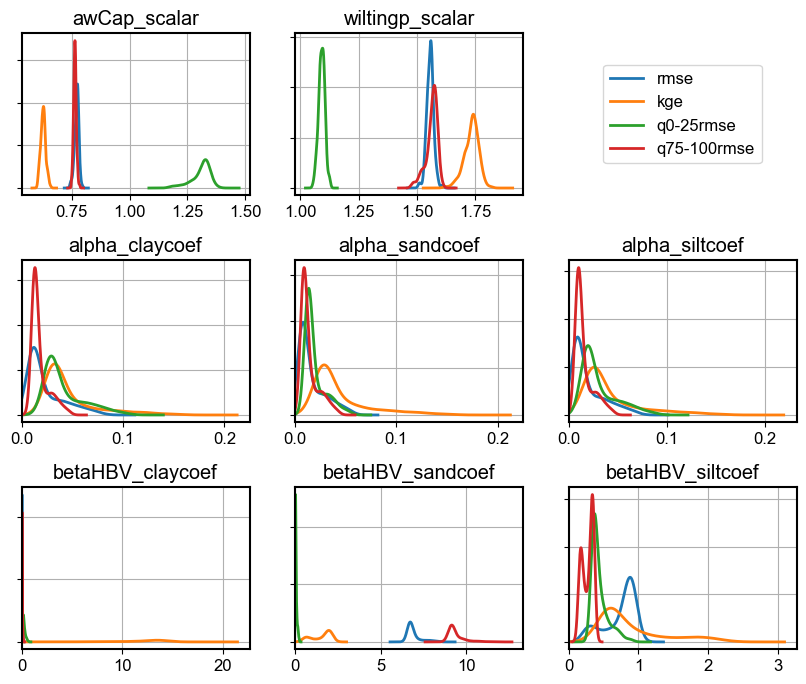

In [70]:
subset_name = 'centralUS'
obs_name = 'NOAH'
thresh = 1.01

fig, axs = plt.subplots(3,3, figsize = (10,8), gridspec_kw={'hspace':0.4})

plot_params(subset_name, obs_name, thresh, ['awCap_scalar', 'wiltingp_scalar'], axs[0,:2])
plot_params(subset_name, obs_name, thresh, ['alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef'], axs[1,:])
plot_params(subset_name, obs_name, thresh, ['betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef'], axs[2,:])

# Legend in odd plot
axs[0,2].axis("off")
axs[0,2].set_xlim(axs[0,2].get_xlim())
axs[0,2].set_ylim(axs[0,2].get_ylim())
handles, labels = axs[0,0].get_legend_handles_labels()
axs[0,2].legend(handles=handles, labels=labels, loc='center')

plt.show()

### Old Plots

In [ ]:
# Read sim
def plot_precal_map(obs, title, ax):
    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/{obs.upper()}_validation.nc')
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip0.csv')
    iparam_best = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[0]
    
    # Read simulation output
    sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/out/{str(iparam_best)}.npy')
    # sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_old/out/{str(iparam)}.npy')

    # Construct xr 
    ds_sim = xr.Dataset(
            data_vars=dict(soilMoist=(["time", "lat", "lon"], np.transpose(sim_tmp, (2,1,0)))),
            coords=dict(
                lon=np.arange(-103.938, -80.5629999, 0.125), # CENTRAL US ONLY!
                lat=np.arange(36.063, 49.313001, 0.125), # CENTRAL US ONLY!
                time=pd.date_range(start='01/01/2016', end='12/31/2022')))
    
    # Plot
    ds_rmse = np.sqrt(((ds_sim['soilMoist'] - ds_obs['soilMoist'])**2).mean(dim='time'))
    p = ds_rmse.plot(ax=ax, vmin=0, vmax=100, add_colorbar=False, levels=11, cmap = "Oranges", transform=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_title(title)
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)

    return p, ds_rmse

In [ ]:
# Read sim
def plot_best_ts(obs_name, n_cutoff, lat, lon, title, ax):
    # For loookup
    def find_nearest(array, value):
        array = np.asarray(array)
        return (np.abs(array - value)).argmin()
        
    # Get correct idx
    lons = np.arange(-103.938, -80.5629999, 0.125)
    lats = np.arange(36.063, 49.313001, 0.125)
    idy = find_nearest(lats, lat)
    idx = find_nearest(lons, lon)

    # Read obs
    ds_obs = xr.open_dataset(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/{obs_name.upper()}_validation.nc')
    obs = ds_obs.sel(lat=lat, lon=lon, method='nearest')['soilMoist'].to_numpy()

    # Get dates
    dates = pd.date_range(start='01/01/2016', end='12/31/2022', periods=len(obs))
    
    # Get top N_cutoff params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/soilMoist_rmse_skip0.csv')
    iparam_top_n = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[:n_cutoff]
    # Get best
    iparam_best = iparam_top_n[0]
    sim_best = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/out/{str(iparam_best)}.npy')

    # For surprise_index
    sim_all = []
    
    # Plot simulations
    for iparam in iparam_top_n:
        # Read
        sim_tmp = np.load(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/out/{str(iparam)}.npy')

        # Plot
        ax.plot(dates, sim_tmp[idx, idy, :], color='silver', alpha=0.8)
        
        # Append for surpise index
        sim_all.append(sim_tmp[idx, idy, :])
    
    # Plot
    ax.plot(dates, obs, color='darkred', zorder=3, label='Obs.')
    ax.plot(dates, sim_best[idx, idy, :], color='gray', zorder=2, label='Best (global)')

    # Info
    best_rmse = np.sqrt(((sim_best[idx, idy, :] - obs)**2).mean())
    best_corr = np.corrcoef(sim_best[idx, idy, :], obs)[0,1]
    
    maxs = np.max(sim_all, axis=0)
    mins = np.min(sim_all, axis=0)
    coverage = 1 - ((((obs > maxs).sum() + (obs < mins).sum())) / len(obs))

    text = f"RMSE: {best_rmse:.2f}mm, Corr.: {best_corr:.2f}, Coverage: {100*coverage:.2f}%"
    ax.text(x=0.03, y=0.96,
            s = text,
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

    ax.grid()
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.set_ylabel("Soil Moisture")
    ax.set_xlabel('')

In [ ]:
def plot_precal_kde(obs_name, color, n_cutoff, param, label, ax):
    df_params = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/params_extra.csv')
    
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs_name.upper()}/soilMoist_rmse_skip0.csv')
        
    iparam_top_n = df_res.sort_values(by='rmse_gpa')['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    df_params.iloc[iparam_top_n][param].plot.kde(ax=ax, color=color, label=label, lw=2)

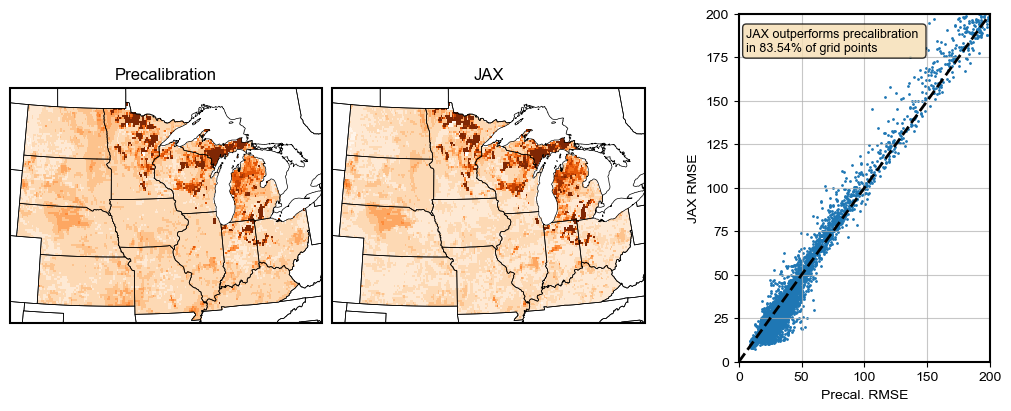

In [183]:
fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 2, wspace=0.07, width_ratios=[2,1])

axsLeft = subfigs[0].subplots(1, 2, subplot_kw=dict(projection=ccrs.LambertConformal()))

obs = 'SMAP'
p, precal_rmse = plot_precal_map(obs, 'Precalibration', axsLeft[0])
p, jax_rmse = plot_jax_map(obs, 'JAX', axsLeft[1])

fig.colorbar(p,
             orientation="horizontal",
             label=f"RMSE [mm]",
             ax=axs[:2],
             shrink=0.5,
             pad=0.04)

# scatter
axsRight = subfigs[1].subplots(1, 1)
ax=axsRight
ax.scatter(x = precal_rmse.to_numpy().flatten(),
            y = jax_rmse.to_numpy().flatten(),
            s=1)

maxlim = np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
ax.plot([0, maxlim], [0, maxlim], lw=2, ls='--', color='black')
ax.set_xlim([0,200])
ax.set_ylim([0,200])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.grid(alpha=0.7)
ax.set_xlabel('Precal. RMSE')
ax.set_ylabel('JAX RMSE')

diffs = precal_rmse.to_numpy().flatten() - jax_rmse.to_numpy().flatten()
diffs = diffs[~np.isnan(diffs)]
ax.text(x=0.03, y=0.96,
        s = f"JAX outperforms precalibration \nin {100*np.mean(diffs > 0.):.2f}% of grid points",
            transform=ax.transAxes,
            verticalalignment='top',
            horizontalalignment='left',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=9)

# plt.savefig('../figs/JAX_presentation/map_scatter_best.png', dpi=600)
plt.show()

In [16]:
# Read JAX
df_out = get_jax_top('SMAP', 1.1)

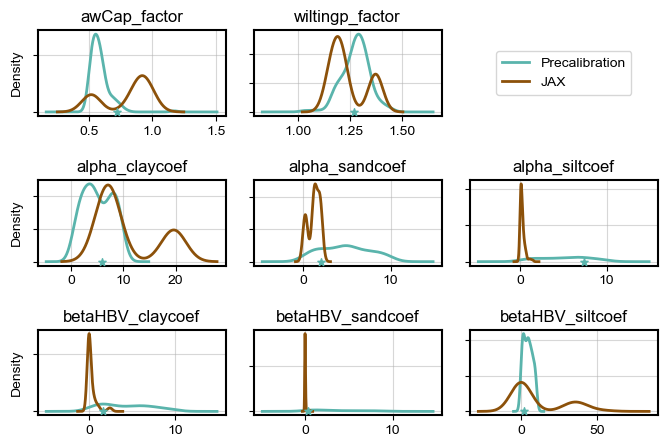

In [54]:
# Do the parameters match?
n_cutoff = 150
metric = 'rmse_gpa'
tmin = 0

#######################
# PRECAL
#######################
# Read params
df_params = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/params_extra.csv')

params = ['awCap_factor',
          'wiltingp_factor',
          'alpha_claycoef', 'alpha_sandcoef', 'alpha_siltcoef',
          'betaHBV_claycoef', 'betaHBV_sandcoef', 'betaHBV_siltcoef']
priors = ['U(0.1, 5)',
          'U(0.1, 5)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)',
          'U(0, 10)', 'U(0, 10)', 'U(0, 10)']
xlims = [[0.1, 3],
          [0.1, 3],
          [0, 10], [0, 10], [0, 10],
          [0, 10], [0, 10], [0, 10]]
# obs_all = ['noah', 'mosaic']
# obs_colors = ['C0', 'C0', 'C0', 'C0']

obs_all = ['smap', 'vic', 'noah', 'mosaic']
obs_colors = ['#5ab4ac', '#8c510a', '#bf812d', '#d8b365']

obs_all = [obs]
obs_colors = ['#5ab4ac']

fig, axs = plt.subplots(3,3, figsize=(8,5), gridspec_kw={'hspace':0.75, 'wspace':0.15})
axs=axs.flatten()

for ido, obs in enumerate(obs_all):
    # Get top params
    df_res = pd.read_csv(f'{project_data_path}/WBM/calibration/centralUS_AGU/{obs.upper()}/soilMoist_rmse_skip{str(tmin)}.csv')
        
    iparam_top_n = df_res.sort_values(by=metric)['iparam'].to_numpy()[:n_cutoff]
    iparam_best = iparam_top_n[0]

    # Loop through params
    for idx, param in enumerate(params):
        if idx >= 2:
            idxx = idx + 1
        else:
            idxx = idx
        # Plot
        df_params.iloc[iparam_top_n][param].plot.kde(ax=axs[idxx], color=obs_colors[ido], label='Precalibration', lw=2)
        # Best
        axs[idxx].scatter(x = [df_params.iloc[iparam_best][param]],
                         y = [0],
                         marker = '*', color=obs_colors[ido], zorder=100, s=30)

###########################
# JAX
#########################
jax_colors = ['#8c510a', '#bf812d']

# Read JAX
df_out = get_jax_best('SMAP', 1.01)

for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    # Best
    np.exp(df_out[param.replace('_factor', '_scalar')]).plot.kde(ax=axs[idxx], color=jax_colors[0], lw=2, label='JAX')
    

# for ido, param_read_str in enumerate(['_rmse_', '_mse_']):
#     file = glob(f'{project_data_path}/WBM/calibration/centralUS/{obs}/training_res/*{param_read_str}*')[0]
#     theta = pd.read_csv(file, sep=';', names = ['info', 'theta']).iloc[-1]['theta'].replace(' theta: ', '').split(',')
#     theta = np.exp([float(x) for x in theta])
#     # Loop through params
#     for idx, param in enumerate(params):
#         if idx >= 2:
#             idxx = idx + 1
#         else:
#             idxx = idx
#         # Best
#         axs[idxx].scatter(x = [theta[idx]],
#                          y = [0],
#                          marker = '^', color=jax_colors[ido], zorder=100, s=30)

# Tidy
for idx, param in enumerate(params):
    if idx >= 2:
        idxx = idx + 1
    else:
        idxx = idx
    axs[idxx].set_title(f'{param}')
    # axs[idxx].set_xlim(xlims[idx])
    axs[idxx].set_yticklabels([])
    axs[idxx].grid(alpha=0.5)
    if idxx not in [0,3,6]:
        axs[idxx].set_ylabel('')
    
# Legend in odd plot
axs[2].axis("off")
axs[2].set_xlim(axs[2].get_xlim())
axs[2].set_ylim(axs[2].get_ylim())
legend_elements = [Line2D([10], [10], color=obs_colors[0], lw=2, label='Precalibration'),
                   Line2D([10], [10], color=jax_colors[0], lw=2, label='JAX')]
                    # Line2D([10], [10], color=obs_colors[3], lw=2, label=obs_all[3].upper()),
                    # Line2D([10], [10], marker='^', markerfacecolor=obs_colors[0], color='w', markersize=9, label='SMAP Best'),
                    # Line2D([10], [10], marker='^', markerfacecolor=jax_colors[0], color='w', markersize=9, label='JAX RMSE'),
                    # Line2D([10], [10], marker='^', markerfacecolor=jax_colors[1], color='w', markersize=9, label='JAX MSE')]

axs[2].legend(handles=legend_elements, loc='center')

plt.show()

In [9]:
# ixy = 14503

# plt.plot(make_prediction(initial_params, constants, x_forcing_nt[ixy, :, :], x_forcing_nyrs[ixy, :], x_maps[ixy, :]))
# plt.plot(ys[ixy,:])
# loss_fn(initial_params,constants,x_forcing_nt[ixy,:,:], x_forcing_nyrs[ixy,:] ,x_maps[ixy,:], ys[ixy,:])